In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output

import numpy as np
import pylab as pl

from src import *

In [3]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 4     # Number of pixels used to pad the target image border
TARGET_SIZE = 20       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5

torch.backends.cudnn.benchmark = True # Speeds up things

In [4]:
# Starting state

def generator(n_images):
    make_seed(n_images, N_CHANNELS, IMAGE_SIZE, alpha_channel=N_CHANNELS)

pool = SamplePool(POOL_SIZE, generator)

IndexError: index 15 is out of bounds for dimension 1 with size 15

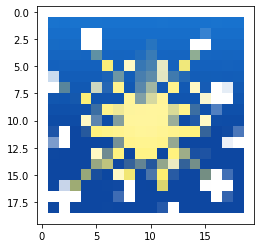

In [4]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

In [6]:
model = MultipleCA(device=device)

In [7]:
params = [*model.CAs[0].parameters(), *model.CAs[1].parameters()]

optimizer = torch.optim.Adam(params, lr=2e-3)
criterion = CustomLoss(pad(target, TARGET_PADDING), [16, 17], torch.nn.MSELoss)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)

model.train_CA(optimizer, criterion, pool, n_epochs=300, skip_update=1, batch_size=16,
               scheduler=scheduler, kind="growing", skip_damage=1)

epoch: 300
avg loss: 0.010580464237136766


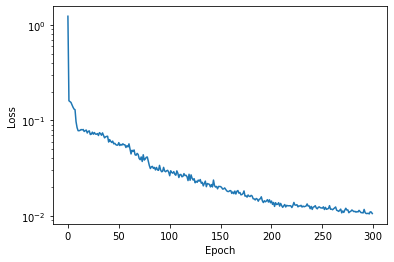

In [8]:
pl.plot(model.losses)
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.yscale("log")
pl.show()
# pl.savefig(fname="perturbation_regeneration_l=1_side=20_losses.png", dpi=200)

In [10]:
def state_to_image(x, n_channels, mask_channels):
    alpha = x[:, n_channels-1:n_channels-1+mask_channels].sum(dim=1).unsqueeze(1)
    return torch.cat((x[:, :3], alpha), dim=1)

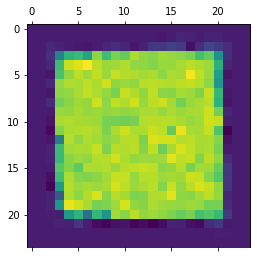

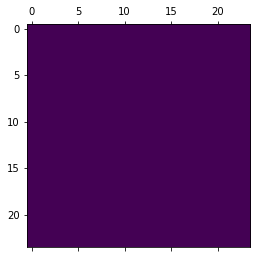

In [28]:
pl.matshow(image[0, -1].cpu())
pl.matshow(image[0, -2].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


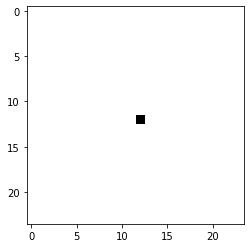

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


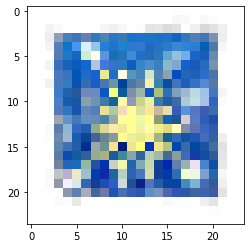

In [27]:
image = pool.sample(1)[0].cuda()

imshow(state_to_image(image, 16, 2).cpu()[0])

image = model.evolve(image.cuda(), 50)
imshow(state_to_image(image, 16, 2).cpu()[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


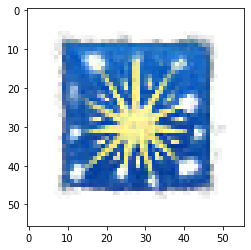

In [17]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

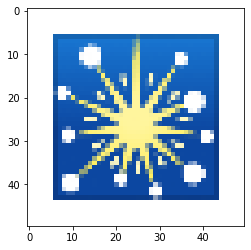

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))